In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import csv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold

In [3]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from dataset_spliter import SplitByPatient
from metrics import *#F1Weighted, MCC
from losses import *
from data_loader import ImageItemListCell
from augmentation import cutout

In [5]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [6]:
hem_regex = re.compile(r'UID_(H[0-9]+)_', re.IGNORECASE)
all_regex = re.compile(r'UID_([0-9]+)_', re.IGNORECASE)

hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))

hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
print()

In [7]:
cutout_fn = TfmLighting(cutout)
xtra_tfms=[cutout_fn(n_holes=5, length=0.1)] #squish(scale=0.66),
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      #max_lighting=0.15, 
                      max_zoom=1, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      #xtra_tfms=xtra_tfms,
                     )

In [8]:
test_path = Path('/data/Datasets/WhiteBloodCancer/test/')

pat = re.compile(r'^.*(hem|all).bmp$')
def get_label(fn):
    return pat.search(str(fn)).group(1)

def get_data(bs, size, train_index, test_index):

    lls = ImageItemList(fnames, path=path)\
        .split_by_idxs(train_index, test_index)\
        .label_from_func(get_label).add_test_folder('../test')
    data = ImageDataBunch.create_from_ll(lls, size=size, bs=bs, ds_tfms=tfms).normalize()
    
    return data

In [9]:
def create_save_point(learn: Learner):
    
    preds_test, y_test=learn.get_preds(ds_type=DatasetType.Valid)# 
    preds_test = np.argmax(torch.sigmoid(preds_test), axis=1)
    score = int(matthews_corrcoef(y_test, preds_test) * 10000)
    
    learn.export('{}-{}-{}.pkl'.format(score, size, experiment_name))  
    
    export_csv(learn, score)

In [10]:
def export_csv(learn: Learner, score):
    
    y_pred, y_test_tta = learn.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.3)
    y_pred = to_np(y_pred)
    
    filename = '{}-{}-{}'.format(score, size, experiment_name)
    with open(str(path)+"/"+ filename+".csv", mode='w') as submission:
        submission_writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        for fn, y in zip(learn.data.test_dl.items, y_pred):
            submission_writer.writerow([fn.name, y[0], y[1]])
            
    submission = [0 for i in range(y_pred.shape[0])]
            
    threshold = 0.5 
    for fn, y in zip(learn.data.test_dl.items, y_pred[:,0]):
        index = int(fn.name.replace(".bmp",'')) - 1
        y = 1 if y > threshold else 0
        submission[index] = y

    with open(str(path)+"/"+ filename+'.predict', 'w') as f:
        for item in submission:
            f.write("{}\n".format(item))

In [11]:
split_handler = SplitByPatient(hem_patients, all_patints)

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.387466,0.393492,0.145199,0.851147,0.387240
2,0.351020,0.480231,0.177986,0.826925,0.324777
3,0.278187,0.347836,0.119438,0.871858,0.461608
4,0.237462,0.393075,0.134660,0.856493,0.396274
5,0.208026,0.376412,0.117096,0.871360,0.457740


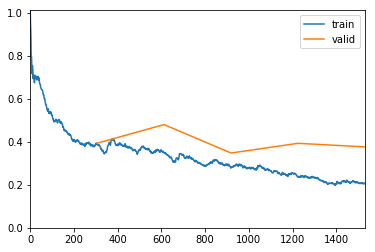

epoch,train_loss,valid_loss,error_rate,f1_weighted,mcc
1,0.241816,0.397115,0.125293,0.868739,0.452932
2,0.267227,0.461781,0.139344,0.807343,0.188732
3,0.258849,0.525529,0.177986,0.819533,0.263456
4,0.230753,0.473244,0.154567,0.840941,0.343188
5,0.227001,0.445019,0.145199,0.836308,0.296219
6,0.193671,0.440641,0.140515,0.827321,0.254709
7,0.192686,0.377650,0.117096,0.871360,0.457740
8,0.188111,0.373957,0.108899,0.876897,0.485445


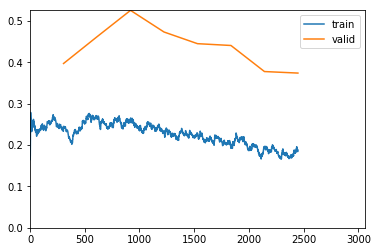

In [ ]:
id = 0
while True:
    train, val, keys = split_handler.split_by_num_patients(fnames)
    
    fold = 0
    for train_index, test_index in zip(train, val):
        size = 256
        bs = 32

        data = get_data(bs, size, train_index, test_index)

        gc.collect()
        experiment_name = 'rn101-Custom-{}-{}'.format(fold, id)
        
        with open(str(path)+"/"+experiment_name+'.txt', 'w') as the_file:
            the_file.write(" ".join(keys))

        learn = create_cnn(data, models.resnet101, 
                       metrics=[error_rate, F1Weighted(), MCC()],  
                       #loss_func=FocalLoss(num_classes=1),
                       #ps=0.75,
                       #wd=0.1,
                       callback_fns=[ShowGraph, partial(SaveModelCallback, name='stage1-{}-{}'.format(experiment_name, size))],
                      )#.to_fp16()

        lr = 1e-2
        learn.fit_one_cycle(5, lr)

        learn.unfreeze()
        learn.callback_fns[2] = partial(SaveModelCallback, 
                                  monitor="mcc", 
                                  mode='max', 
                                  name='stage2-{}-{}'.format(experiment_name, size))
        learn.fit_one_cycle(10, slice(1e-5,lr/5))

        ####################################### 384

        size = 384
        bs = 16
        learn.freeze()

        learn.data = get_data(bs, size, train_index, test_index)
        learn.callback_fns[2] = partial(SaveModelCallback, 
                                  monitor="mcc", 
                                  mode='max', 
                                  name='stage1-{}-{}'.format(experiment_name, size))
        learn.fit_one_cycle(5, slice(1e-5,lr/5))

        learn.unfreeze()
        learn.callback_fns[2] = partial(SaveModelCallback, 
                                  monitor="mcc", 
                                  mode='max', 
                                  name='stage2-{}-{}'.format(experiment_name, size))
        learn.fit_one_cycle(10, slice(1e-5,lr/5))

        create_save_point(learn)
        ####################################### 450


        size = 450
        bs = 8
        learn.freeze()

        learn.data = get_data(bs, size, train_index, test_index)
        learn.callback_fns[2] = partial(SaveModelCallback, 
                                  monitor="mcc", 
                                  mode='max', 
                                  name='stage1-{}-{}'.format(experiment_name, size))
        learn.fit_one_cycle(5, slice(1e-5,lr/5))

        learn.unfreeze()
        learn.callback_fns[2] = partial(SaveModelCallback, 
                                  monitor="mcc", 
                                  mode='max', 
                                  name='stage2-{}-{}'.format(experiment_name, size))
        learn.fit_one_cycle(10, slice(1e-5,lr/5))

        create_save_point(learn)

        fold += 1    
        id += 1
    